# Auto-encoder


In [3]:
###### -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.utils import *

# Load data
k = 8
n = 16

elements = list(get_all_possible_words(k))

def train_autoencoder(EbN0dB, nb_epochs=10_000):
    # Create models
    # Encoder
    encoder_model=Sequential()
    encoder_model.add(Dense(128, activation='relu', input_dim=k))
    encoder_model.add(Dense(64, activation='relu'))
    encoder_model.add(Dense(32, activation='relu'))
    
    encoder_model.add(Dense(n, activation='tanh')) # We use tanh for BPSK

    # Decoder
    decoder_model=Sequential()
    decoder_model.add(Dense(32, activation='relu', input_dim=n))
    decoder_model.add(Dense(64, activation='relu'))
    decoder_model.add(Dense(128, activation='relu'))
    decoder_model.add(Dense(k, activation='sigmoid')) # We use sigmoid for bits

    # Merge both to autoencoder
    noise_power = calculate_noise_power(EbN0dB, 1, k, n, 1)
    noise_std = np.sqrt(1./2. * noise_power)
    noisy_model=Sequential()
    noisy_model.add(encoder_model)
    noisy_model.add(GaussianNoise(noise_std, input_shape=(n,)))
    noisy_model.add(decoder_model)

    noisy_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    
    print(noisy_model.summary())
    
    t = time.time()
    noisy_history = noisy_model.fit(
        np.array(elements), 
        np.array(elements), 
        epochs=nb_epochs, 
        verbose=0
    )
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')
    
    # Save models
    encoder_model.save(f'networks/autoencoder/autoencoder_encoder_{EbN0dB}-{nb_epochs}.h5')
    decoder_model.save(f'networks/autoencoder/autoencoder_decoder_{EbN0dB}-{nb_epochs}.h5')

if __name__ == '__main__':
    # Tests have shown best results for 5dB noise
    train_autoencoder(5)
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 16)                12016     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 16)                0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 8)                 12008     
Total params: 24,024
Trainable params: 24,024
Non-trainable params: 0
_________________________________________________________________
None
Elapsed : 579.44 s


Using TensorFlow backend.
C:\Users\Thibault\Anaconda3\envs\PythonGPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Start simulation with network trained at 5 dB and 10000 epochs
Start EbN0 1/10 [-5.0] /1000 [163.5 %] | Ended in 0.41 s
Start EbN0 2/10 [-3.56] /1000 [143.1 %] | Ended in 0.05 s
Start EbN0 3/10 [-2.11] /1000 [104.4 %] | Ended in 0.06 s
Start EbN0 4/10 [-0.67] /1000 [74.7 %][151.8 %] | Ended in 0.11 s
Start EbN0 5/10 [0.78] /1000 [49.4 %][98.9 %][149.1 %] | Ended in 0.17 s
Start EbN0 6/10 [2.22] /1000 [29.1 %][54.4 %][83.1 %][110.9 %] | Ended in 0.2 s
Start EbN0 7/10 [3.67] /1000 [12.4 %][27.0 %][39.6 %][51.3 %][63.3 %][76.9 %][88.2 %][101.0 %] | Ended in 0.41 s
Start EbN0 8/10 [5.11] /1000 [10.8 %][21.4 %][32.3 %][41.6 %][52.9 %][61.6 %][70.6 %][84.7 %][94.7 %][104.3 %] | Ended in 1.16 s
Start EbN0 9/10 [6.56] /1000 [11.3 %][21.3 %][30.3 %][41.3 %][50.2 %][60.2 %][70.3 %][80.3 %][90.3 %][100.5 %] | Ended in 5.1 s
Start EbN0 10/10 [8.0] /1000 [10.1 %][20.4 %][30.3 %][40.3 %][50.1 %][60.1 %][70.5 %][80.6 %][90.4 %][100.1 %] | Ended in 25.28 s


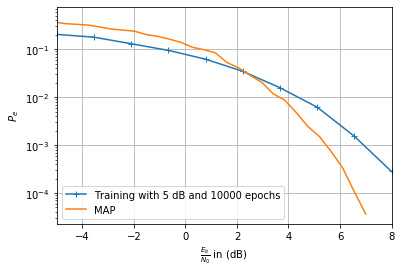

Elapsed : 34.88 s


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import load_model

from src.communications import *
from src.utils import *

# Configuration
EbN0dBs = np.linspace(-5, 8, 10)

BPS = 1
k = 8
n = 16

channel = AWGNChannel(BPS, k, n)

block_elements = list(get_all_possible_words(k))

def get_channel_fct(encoder_model, decoder_model):
    transmitter = NetworkTransmitter(k, n, encoder_model, NeuralNetworkType.INTEGER)
    receiver = NetworkReceiver(k, n, decoder_model, NeuralNetworkType.INTEGER)
    
    return get_basic_channel_fct(transmitter, channel, receiver)

    
if __name__ == '__main__':
    t = time.time()
    
    # Get all trained networks
    elts = {}
    for file in os.listdir("networks/autoencoder"):
        if file.endswith(".h5"):
            [_, elt_type, elt_db] = file.replace('.h5', '').split('_')
            if elt_db not in elts.keys():
                elts[elt_db] = {}
            
            elts[elt_db][elt_type] = load_model(f'networks/autoencoder/{file}')
    
    # Plot results
    [EbN0dBs_C, BER_C] = np.loadtxt('outputs/BER_G_MAP.csv', delimiter=',')
    
    plt.figure()
    
    # Simulation
    legend = []
    symbols = ['+', 'x', 'o', '*']
    for (i, training_EbN0dB) in enumerate(elts.keys()):
        [t_db, t_epochs] = training_EbN0dB.split('-')
        
        print(f'\nStart simulation with network trained at {t_db} dB and {t_epochs} epochs')
        legend.append(f'Training with {t_db} dB and {t_epochs} epochs')
        
        BER = ber_performance(
            EbN0dBs,
            get_channel_fct(
                elts[training_EbN0dB]['encoder'], 
                elts[training_EbN0dB]['decoder']
            ),
            k * 1000,
            1000
        )
        plt.plot(EbN0dBs, BER, symbols[i % len(symbols)] + '-')
        
        np.savetxt(
            f'outputs/BER_autoencoder_{training_EbN0dB}.csv', 
            [np.array(EbN0dBs), np.array(BER)], delimiter=','
        )

    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(legend + ['MAP'])
    plt.grid()
    
    plt.xlabel('$\\frac{E_b}{N_0}$ in (dB)')
    plt.ylabel('$P_e$')
    plt.yscale('log')
    plt.xlim(np.min(EbN0dBs), np.max(EbN0dBs))
    
    plt.show()
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')


We have done numerous tests on several noise values, and with several types of networks.
The analysis of the results showed that the best performances were obtained with a butterfly shaped network, and with a training noise of 5 dB.

The graph presented above was trained with 10 000 epochs, the increase of the number of epochs allows to lower the curve in the high values of the signal-to-noise ratio, but does not really change the intersection point with the curve. An additional bibliographical study has shown that a cut-off around 2dB was the best that could be done at the moment.